> Martin Fridrich 01/2025

# Waste product classification

## Data

In [2]:
#%pip install -q -r dl-env-requirements.txt

In [3]:
# print out tf version
import tensorflow as tf
print(f"Installed tensorflow version: {tf.__version__}")

2025-01-14 07:25:09.992144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736835910.003210   53416 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736835910.006453   53416 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 07:25:10.020067: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Installed tensorflow version: 2.18.0


In [4]:
import os
import zipfile
import requests

class DataUtils():

    # Data download and extraction

    def __init__(self):
        self.data_dir = "data"
        self.data_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kd6057VPpABQ2FqCbgu9YQ/o-vs-r-split-reduced-1200.zip"
        self.data_file = "o-vs-r-split-reduced-1200.zip"
        self.validation_split = 0.2
        self.img_size = (150, 150)
        self.batch_size = 32

    def download_data(self):
        if not os.path.exists(self.data_dir):
            os.makedirs(self.data_dir)
            
        data_path = os.path.join(self.data_dir, self.data_file)
        
        if not os.path.exists(data_path):
            print("Downloading data...")
            response = requests.get(self.data_url)
            with open(data_path, "wb") as f:
                f.write(response.content)
            
            print("Extracting data...")
            with zipfile.ZipFile(data_path, "r") as zip_ref:
                zip_ref.extractall(self.data_dir)
            
            #print("Removing zip file...")
            #os.remove(data_path)
            
            print("Data download and extraction completed.")
        else:
            print("Data already exists.")
        
        return self
    # Data generators

    def _get_train_augmentation(self):
        return tf.keras.preprocessing.image.ImageDataGenerator(
            validation_split=self.validation_split,
            rescale=1.0/255.0,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True
        )
    
    def _get_validation_augmentation(self):
        return tf.keras.preprocessing.image.ImageDataGenerator(
            validation_split=self.validation_split,
            rescale=1.0/255.0)

    def _get_test_augmentation(self):
        return tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

    def initialize_data_generators(self):
        train_datagen = self._get_train_augmentation()
        validation_datagen = self._get_validation_augmentation()
        test_datagen = self._get_test_augmentation()

        common_params = {
            "target_size": self.img_size,
            "batch_size": self.batch_size,
            "class_mode": "binary"
        }

        self.train_generator = train_datagen.flow_from_directory(
            os.path.join(self.data_dir, "o-vs-r-split/train/"),
            subset="training",
            **common_params)
        
        self.validation_generator = validation_datagen.flow_from_directory(
            os.path.join(self.data_dir, "o-vs-r-split/train/"),
            subset="validation",
            **common_params)
        
        self.test_generator = test_datagen.flow_from_directory(
            os.path.join(self.data_dir, "o-vs-r-split/test/"),
            shuffle=False,
            **common_params)
        
        return self

data = DataUtils().download_data().initialize_data_generators()
print(f"Train data generator consists of  {len(data.train_generator)} batches.")

Extracting data...
Data download and extraction completed.
Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Train data generator consists of  25 batches.


## Modeling

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

tf.keras.mixed_precision.set_global_policy('mixed_float16')

class Modeling():
    def __init__(self, data, model_name):
        self.data = data
        self.model_name = model_name
        self.model = None
        self.history = None
        self.feature_extractor = None

    def load_feature_extractor(self, trainable_layers=[]):
        vgg = tf.keras.applications.VGG16(
            include_top=False,
            weights="imagenet",
            input_shape = data.img_size + (3,))
        
        for layer in vgg.layers:
            if layer.name not in trainable_layers:
                layer.trainable = False
            else:
                layer.trainable = True

        output = vgg.layers[-1].output
        output = tf.keras.layers.Flatten()(output)
        self.feature_extractor = tf.keras.Model(vgg.input, output)
        self.feature_extractor.quantize("float8")
        return self
    
    def build_model(self):
        inputs = tf.keras.layers.Input(shape=data.img_size + (3,))
        x = self.feature_extractor(inputs, training=False)
        x = tf.keras.layers.Dense(512, activation="relu")(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(512, activation="relu")(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
        self.model = tf.keras.Model(inputs, outputs)
        self.model.name = self.model_name
        return self
    
    def compile_model(self):
        self.model.compile(
            optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
            loss="binary_crossentropy",
            metrics=["accuracy"])
        return self
    
    def _get_callbacks(self):

        class LossHistory(tf.keras.callbacks.Callback):
            def on_train_begin(self, logs={}):
                self.losses = []
                self.lr = []
                
            def on_epoch_end(self, epoch, logs={}):
                self.losses.append(logs.get("loss"))
                self.lr.append(exp_decay(epoch))
                print("lr:", exp_decay(len(self.losses)))

        def exp_decay(epoch):
            base_lr = 1e-4
            k = 0.1
            return base_lr * np.exp(-k*epoch)
        
        return [LossHistory(),
            tf.keras.callbacks.LearningRateScheduler(exp_decay),
            tf.keras.callbacks.EarlyStopping(
                monitor = "val_loss", patience = 4, mode = "min", min_delta=0.01),
            tf.keras.callbacks.ModelCheckpoint(
                self.model_name+".keras", monitor="val_loss", save_best_only=True, mode="min")]

    def train_model(self, epochs=10):
        self.history = self.model.fit(
            self.data.train_generator,
            validation_data=self.data.validation_generator,
            epochs=epochs,
            verbose=1,
            callbacks = self._get_callbacks())
        return self
    
    def plot_history(self):
        
        acc = self.history.history["accuracy"]
        val_acc = self.history.history["val_accuracy"]
        loss = self.history.history["loss"]
        val_loss = self.history.history["val_loss"]
        epochs = range(len(acc))

        f, ax = plt.subplots(1, 2, figsize=(14, 6))

        ax[0].plot(epochs, acc, "r", label="Training accuracy")
        ax[0].plot(epochs, val_acc, "b", label="Validation accuracy")
        ax[0].set_title("Training and validation accuracy")
        ax[0].legend()

        ax[1].plot(epochs, loss, "r", label="Training Loss")
        ax[1].plot(epochs, val_loss, "b", label="Validation Loss")
        ax[1].set_title("Training and validation loss")
        ax[1].legend()
        
        plt.tight_layout()
        plt.show()
        return self
    
    def print_classification_report(self):
        
        y_raw_pred = self.model.predict(self.data.test_generator, verbose=0)
        y_pred = np.round(y_raw_pred, decimals=0).astype(np.int32)
        y_true = self.data.test_generator.classes
        print(classification_report(y_true, y_pred))
        return self
    
    def plot_test_prediction(self, index=0):
        y_raw_pred = self.model.predict(self.data.test_generator, verbose=0)
        y_pred = np.round(y_raw_pred, decimals=0).astype(np.int32)
        y_true = self.data.test_generator.classes
        classes = {v: k for k, v in self.data.test_generator.class_indices.items()}

        f, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(self.data.test_generator[index][0][0])
        ax[0].set_title(f"True: {classes[y_true[index]]}, Pred: {classes[y_pred[index][0]]}")
        ax[0].axis("off")
        
        probs = np.array([1 - y_raw_pred[index][0], y_raw_pred[index][0]])
        ax[1].bar(classes.values(), probs)
        ax[1].set_title("Prediction probabilities")
        f.suptitle(f"Model: {self.model_name}")
        plt.xticks(rotation=45)
        plt.show()
        return self


In [6]:
# model training
freezed_model = Modeling(data, "freezed_or_vgg16").load_feature_extractor()\
    .build_model().compile_model().train_model(epochs=25)

finetuned_model = Modeling(data, "finetuned_or_vgg16").load_feature_extractor(trainable_layers=["block5_conv3"])\
    .build_model().compile_model().train_model(epochs=25)

I0000 00:00:1736835917.830333   53416 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9799 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:09:00.0, compute capability: 8.6
/mnt/Data/git_root/ibm-ai-engineering/.dl-env/lib/python3.12/site-packages/keras/src/models/model.py:389: UserWarning: Layer InputLayer does not have a `quantize` method implemented.
  warnings.warn(str(e))
/mnt/Data/git_root/ibm-ai-engineering/.dl-env/lib/python3.12/site-packages/keras/src/models/model.py:389: UserWarning: Layer Conv2D does not have a `quantize` method implemented.
  warnings.warn(str(e))
/mnt/Data/git_root/ibm-ai-engineering/.dl-env/lib/python3.12/site-packages/keras/src/models/model.py:389: UserWarning: Layer MaxPooling2D does not have a `quantize` method implemented.
  warnings.warn(str(e))
/mnt/Data/git_root/ibm-ai-engineering/.dl-env/lib/python3.12/site-packages/keras/src/models/model.py:389: UserWarning: Layer Flatten does not have

Epoch 1/25


I0000 00:00:1736835919.931938   57607 service.cc:148] XLA service 0x7f8b7c010250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736835919.931963   57607 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-01-14 07:25:19.976501: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736835920.199319   57607 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/25 ━━━━━━━━━━━━━━━━━━━━ 1:46 4s/step - accuracy: 0.3125 - loss: 1.1423

I0000 00:00:1736835922.970404   57607 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5534 - loss: 0.7978

2025-01-14 07:25:26.923896: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_252', 4 bytes spill stores, 4 bytes spill loads

2025-01-14 07:25:26.981862: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_252', 12 bytes spill stores, 12 bytes spill loads

2025-01-14 07:25:27.045896: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_239', 8 bytes spill stores, 8 bytes spill loads



lr: 9.048374180359596e-05
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.5570 - loss: 0.7927 - val_accuracy: 0.6950 - val_loss: 0.5701 - learning_rate: 1.0000e-04
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6782 - loss: 0.5916lr: 8.187307530779819e-05
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.6794 - loss: 0.5899 - val_accuracy: 0.7450 - val_loss: 0.4969 - learning_rate: 9.0484e-05
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7969 - loss: 0.4667lr: 7.408182206817179e-05
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.7966 - loss: 0.4670 - val_accuracy: 0.8200 - val_loss: 0.4219 - learning_rate: 8.1873e-05
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8005 - loss: 0.4516lr: 6.703200460356394e-05
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.8007 - loss: 0.4518 - val_accuracy: 0.8500 - val_loss: 0.3641 - learning_rate: 7.4082e-05
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 

## Overview

In [7]:
freezed_model.model.summary()

Model: "freezed_or_vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 8192)           │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,636,808 (90.17 MB)

 Trainable params: 4,460,033 (17.01 MB)

 Non-trainable params: 14,716,736 (56.14 MB)

 Optimizer params: 4,460,039 (17.01 MB)

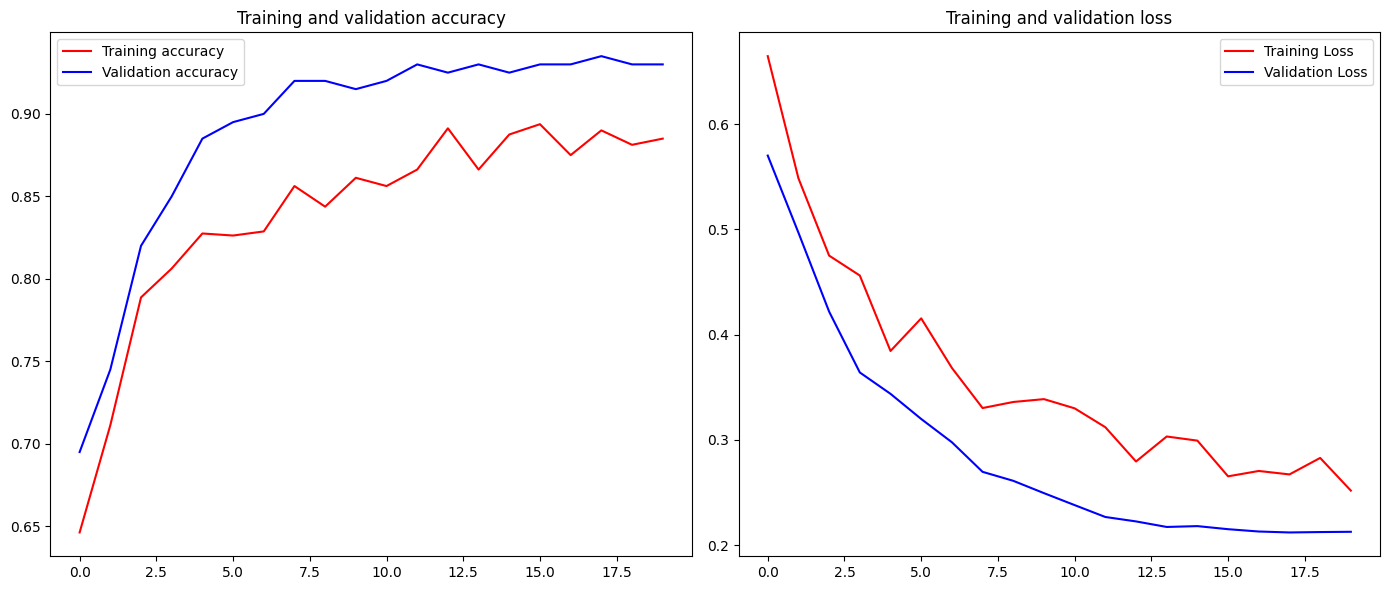

In [8]:
freezed_model.plot_history();

In [9]:
freezed_model.print_classification_report();

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       100
           1       0.89      0.85      0.87       100

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.87       200
weighted avg       0.88      0.88      0.87       200



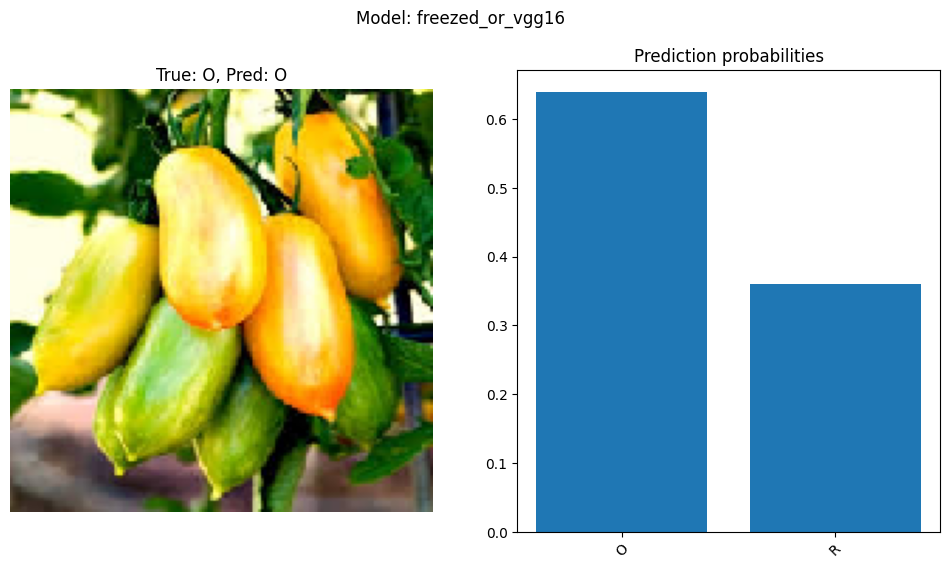

In [10]:
freezed_model.plot_test_prediction(index=1);

In [11]:
finetuned_model.model.summary();

Model: "finetuned_or_vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_2 (Functional)       │ (None, 8192)           │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,996,616 (99.17 MB)

 Trainable params: 6,819,841 (26.02 MB)

 Non-trainable params: 12,356,928 (47.14 MB)

 Optimizer params: 6,819,847 (26.02 MB)

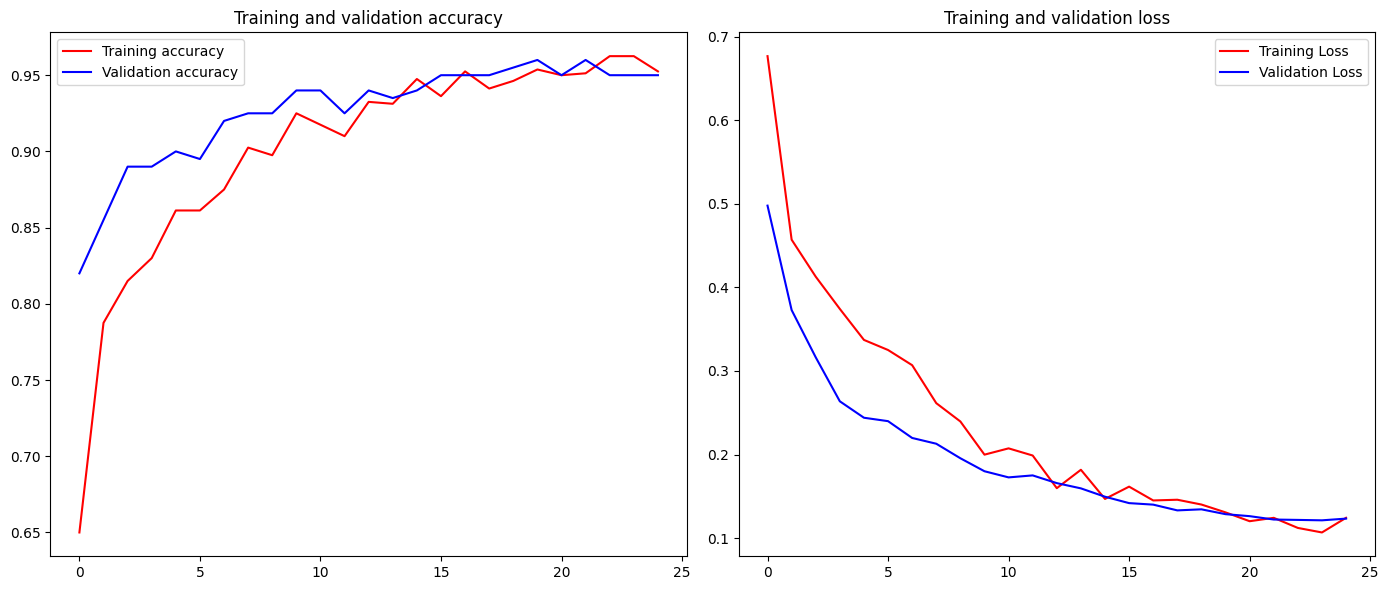

In [12]:
finetuned_model.plot_history();

In [13]:
finetuned_model.print_classification_report();

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       100
           1       0.88      0.86      0.87       100

    accuracy                           0.87       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.87      0.87      0.87       200



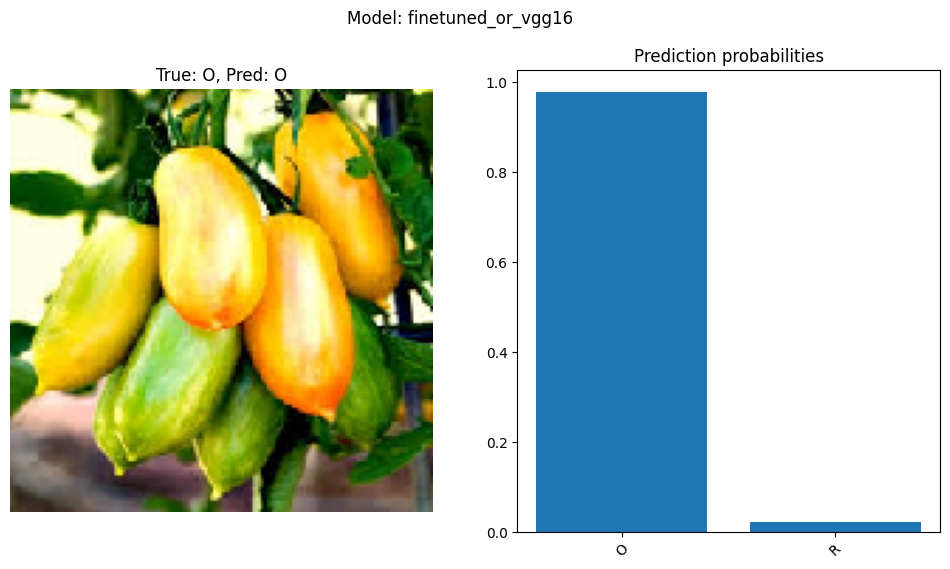

In [14]:
finetuned_model.plot_test_prediction(index=1);

#